In [1]:
import pandas as pd
import numpy as np
import tqdm
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
%pylab inline
from datetime import timedelta

Populating the interactive namespace from numpy and matplotlib


if pc memory capacity wont be enought, can be done with dask library or by loading chunk by chunk

In [2]:
dt = pd.read_csv('pp-complete.csv', skip_blank_lines=True, header=None, dtype='category')

dt.columns = ['id', 'price', 'date', 'Postcode', 
              'Property Type', 'Old_New', 'Duration', 
              'PAON','SAON','Street','Locality', 'Town/City','District', 
              'County', 'PPD Category Type', 'Record Status']

dt['date'] = pd.to_datetime(dt['date'], errors ='coerce')
dt['price'] = pd.to_numeric(dt['price'], downcast='integer')

dt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24020161 entries, 0 to 24020160
Data columns (total 16 columns):
id                   category
price                int32
date                 datetime64[ns]
Postcode             category
Property Type        category
Old_New              category
Duration             category
PAON                 category
SAON                 category
Street               category
Locality             category
Town/City            category
District             category
County               category
PPD Category Type    category
Record Status        category
dtypes: category(14), datetime64[ns](1), int32(1)
memory usage: 3.7 GB


In [3]:
dt = dt[dt['PPD Category Type'] =='A']

# Data Cleaning

#### Price

Lets look at price dynamic, yearly

In [4]:
dt['year'] = dt['date'].dt.year

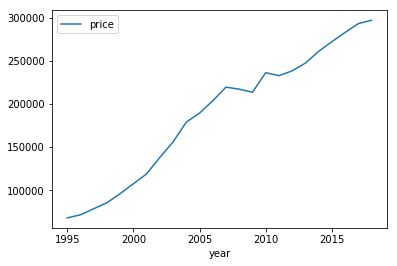

In [18]:
y_l = dt[['year', 'price']].groupby('year').mean()
y_l.plot()

as price is constantly rising the better decision will be to model time series separately from main price model. Intermidiate solutions can be:
* standartize price for each year/month
* include year variable to the model is the form : 0,1,....20

In [6]:
dt['year_index'] = int(dt['year'].max() - dt['year'].min())

Will make fast liearn model to predict mean price for 2015 y

In [7]:
y_l_list = y_l.price.tolist()

In [8]:
from sklearn.linear_model import LinearRegression
x = np.array(range(len(y_l))).reshape(-1, 1)
reg = LinearRegression().fit(x, y_l_list)
print(reg.score(x, y_l_list), reg.coef_, reg.intercept_ )

(0.9756442298443937, array([10545.41379358]), 66241.1773237361)


In [19]:
y_l = y_l.reset_index(drop=False)
print(y_l[y_l['year']==2015].index)

Int64Index([20], dtype='int64')


In [10]:
y_2015 = reg.predict(np.array([[20]]))
y_2015

array([277149.45319537])

Evidently the same should be done with volatility. Not to spend time, will take the std for 2014 year as a proxy

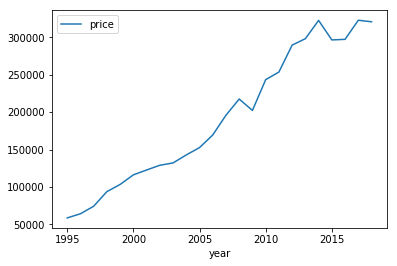

In [11]:
y_std = dt[['year', 'price']].groupby('year').std()
y_std.plot()

In [12]:
y_2015_std = y_std.loc[2014][0]

In [13]:
y_2015_std

322702.69289264706

Standartize price on yearly basis

In [14]:
prices_bu = dt[['year', 'price']]

In [22]:
y_l = y_l.set_index('year').to_dict()['price']
y_std = y_std.to_dict()['price']

yy = dt['year'].unique()

for y in yy:
    dt['price'] = np.where(dt['year']==y, (dt['price'] - y_l[y])/y_std[y], dt['price'])

#### Categorical vars

In [23]:
dt.describe(include='category')

,id,Postcode,Property Type,Old_New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status
count,23435355,23417898,23435355,23435355,23435355,23431143,2659126,23087234,16393782,23435355,23435355,23435355,23435355,23435355
unique,23435355,1210355,4,2,3,417888,36923,304740,22965,1170,454,127,1,1
top,{84C4AAD4-F61F-4B42-B967-3480873579D3},BS3 3NG,T,N,F,2,FLAT 2,HIGH STREET,LONDON,LONDON,BIRMINGHAM,GREATER LONDON,A,A
freq,1,303,7174145,21004743,17940297,585649,149363,143460,901915,1819460,344293,3061230,23435355,23435355


If variable has small number of unique values, then will use dummy. With highly variative variables as a proxy of a group will use standartized mean price.

In [24]:
dt = dt.drop(columns=['id', 'Postcode', 'date', 'PAON', 'SAON', 'Record Status',
                        'PPD Category Type'])

In [25]:
dt = pd.get_dummies(data=dt, columns=['Property Type', 'Old_New', 'Duration'])

In [26]:
for g in ['Street', 'Locality', 'Town/City', 'County', 'District']:
    cc = dt[dt['year']<2015][[g,'price']].groupby(g).mean()
    m = mean(cc['price'])

    cc['price'] = cc['price']/m-1
    cc = cc.to_dict()['price']

    dt[g] = dt[g].apply(lambda x: cc[x])

    dt[g]=pd.to_numeric(dt[g], downcast = 'float')

In [27]:
dt_test = dt[dt['year'] == 2015]
dt_train = dt[dt['year'] < 2015]

In [28]:
dt_train.head()

,price,Street,Locality,Town/City,District,County,year,year_index,Property Type_D,Property Type_F,Property Type_S,Property Type_T,Property Type_O,Old_New_N,Old_New_Y,Duration_F,Duration_L,Duration_U
0,0.923993,8.842290,-0.705254,-17.849262,5.595563,0.879991,1995,23,1,0,0,0,0,1,0,1,0,0
1,-0.528149,-8.691845,-1.652346,-9.598667,2.375140,-0.988482,1995,23,0,0,0,1,0,1,0,1,0,0
2,0.437098,-1.590586,-0.159079,19.822622,-7.362062,-5.450375,1995,23,1,0,0,0,0,1,0,1,0,0
3,-0.613569,-5.256212,-1.957712,-21.827385,8.479965,1.232987,1995,23,0,0,0,1,0,1,0,1,0,0
4,-0.511065,-4.413632,-1.884698,-18.971687,5.612983,0.872550,1995,23,0,0,0,1,0,1,0,1,0,0


Split on train/test

In [29]:
x_test = dt_test[dt_test.drop(columns=['price', 'year']).columns.tolist()]
y_test = dt_test['price']

x_train = dt_train[dt_train.drop(columns=['price', 'year']).columns.tolist()]
y_train = dt_train['price']

# Model and predictions

In [30]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

In [31]:
model = XGBRegressor( subsample=.5, n_jobs=-1)
model.fit(x_train, y_train)

[16:28:36] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

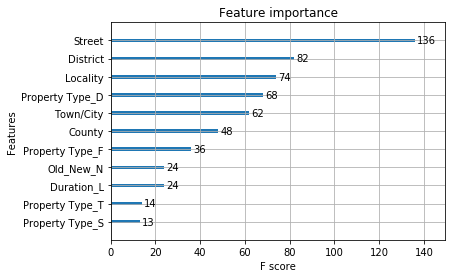

In [32]:
plot_importance(model)

In [33]:
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

In [34]:
from sklearn.metrics import mean_absolute_error, r2_score
print('Train ------------')
print(mean_absolute_error(y_train, y_pred_train))
print('Test ------------')
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Train ------------
0.30531891270499756
Test ------------
0.28671717923941953
0.4649325836521029


In [35]:
y_test = prices_bu[prices_bu['year'] == 2015]['price'].tolist()
y_pred = [i*y_2015_std + y_2015[0] for i in y_pred]
print('Test ------------')
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

Test ------------
86840.11943449808
0.47074881479112596


In [36]:
np.average(y_pred)

274515.7238903452

In [37]:
np.average(y_test)

271998.8000481917